## Quantum Key Distribution

<img src="https://github.com/praveentn/ml-repos/blob/master/qc/qiskit/qkd/qkd_bb84_protocol_1.gif?raw=true" />

### Simulation on QASM Simulator

**Alice** wants to send a secret message to **Bob**  

In [1]:
# load libraries
import qiskit
import math
import numpy as np
from qiskit import Aer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Set backend as the QASM Simulator

In [2]:
# define backend from the simulator
backend = Aer.get_backend('qasm_simulator')
backend

QasmSimulator('qasm_simulator')

## Part 1: Define the message 

Enter a message that you would like to transmit to Bob. The default message is 'Hello world'.

The cell below takes the input message and defines the 'length of message' (slightly longer than the actual message). This will be useful to generate our key. The longer this `len_message`, the better. (Keep it 3x to be on the safe side)

In [3]:
# this block deals with the breaking of message into small chunks, need small chunks if you have small number of qubits

# used for debugging
# message = ''

# message = input('Enter a short message (default message is "Hello World") : ')
message = ''

if len(message) < 1:
    message = 'Hello Praveen'
print('The message to be sent is "', message, '"')

# initial size of encryption key, arbitary number to multiply so that len of string/key is longer than the actual message!
len_message = len(message) * 3
print("message length:", len_message)

The message to be sent is " Hello Praveen "
message length: 39


Define the number of qubits of the system that will be used to process. Since we need to generate a random string of binary numbers, we need to restrict it with the maximum available qubits. We then divide the message into chunks of maximum available qubits (default 5 qubits).

In [4]:
# define number of qubits
num_qbits = 5

# break message into small chunks with lengths <= 5 (using 5 qubit systems)
break_message = []

# break the len_message into chunks of size 5 or less
for i in range(int(len_message / num_qbits)):
    break_message.append(num_qbits)

print(break_message)

if len_message % num_qbits != 0:
    break_message.append(len_message % num_qbits)

print(break_message)

# print the results
print('Key length = length of message |', len_message)

# shows how the message will be broken down
print('The message is broken into chunks:', break_message)

[5, 5, 5, 5, 5, 5, 5]
[5, 5, 5, 5, 5, 5, 5, 4]
Key length = length of message | 39
The message is broken into chunks: [5, 5, 5, 5, 5, 5, 5, 4]


As you can see from the above step, the message of length of message will be equal to length of the key, however this is subdivided into small bits (of size <5 bits) so that we can generate a 5 bit random binary string.

# Breakdown of the BB84 Protocol

**Alice** wants to send the above message to **Bob** .

1) Alice will generate a random string of binary numbers whose length will be equal to the length of the message (or greater)

2) Alice will convert this string into corresponding quibits. But, she will put them into a superposition before sending it to Bob.

3) Alice will send this superposition to Bob

4) Bob recieves this superposition and randomly rotates it in the opposite direction

5) Now, Alice and Bob will publicly share the keys with which the qubits were rotated, when they did the same thing, both can calculate a similar key. (In theory it should be the same)

6) Alice and Bob create their keys which will be used to encode message by Alice and decode the message at Bob's side

## Random String Generator
- The input is size of the string that needs to be generated
- The output is the random string of binary digits

In [5]:
# generate a random key to encrypt the message
# random string generator of str_len (the length of the string)
# this generates the initial key as per the length of string

# QRNG (Hadamard Protocol)
def RandomStringG(str_len):
    # define a empty output string that will be returned
    op_str = ''

    # run this in chuncks of 5 cubits, new output will will appended to a string 
    # sent parameter/argument
    n = str_len

    # 5 qubit chunks
    temp_n = num_qbits

    # consider the upper limit of the division
    for i in range (math.ceil(n/temp_n)):
        q = QuantumRegister(temp_n)
        c = ClassicalRegister(temp_n)
        qc = QuantumCircuit(q, c)

        # this will generate a circuit which will output a ranomly 1s or 0s in chunks of 5 bits/units
        for i in range (temp_n):    
            qc.h(q[i])
            qc.measure(q[i], c[i])

        # execute and store/append the results  in op_str
        # generates a 5bit binary number randomly, as n=5
        op_str += list(execute(qc, backend, shots=1).result().get_counts(qc).keys())[0]  

    return op_str[:n]

The circut to generate random binary numbers using a 5 bit quantum computer. This gives out a 5 bit random binary number.

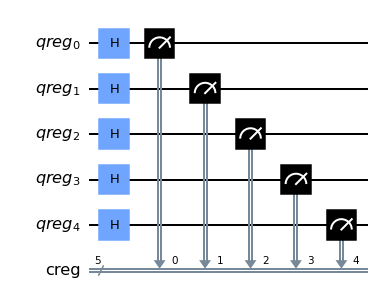

In [6]:
q = QuantumRegister(num_qbits, name='qreg')
c = ClassicalRegister(num_qbits, name='creg')
qc = QuantumCircuit(q, c)

# H gate on all qubits
for i in range(num_qbits):
    qc.h(q[i])
    qc.measure(q[i], c[i])

qc.draw('mpl')

Alice will generate a random key called Initial Key. This will be used to generate the encryption key.

**Only Alice will have this key -** (Initial Key)

In [7]:
# this is the Initial Key that Alice generates and will be used to generate the encryption and so on
key = RandomStringG(len_message)
print('Initial Key (string):', key)

Initial Key (string): 111000111100110100001110010010110001011


Now, Alice will generate a random string of binary numbers again. This will be transmitted to Bob.

In [8]:
# generate a random string of binary digits which Alice will send to Bob
A_rot = RandomStringG(len_message)
print('Alice\'s Rotation Key:', A_rot)

Alice's Rotation Key: 000001010100110110010011100111110000001


Similarly, Bob will generate a random string. Bob will send this to Alice.

In [9]:
# at the same time Bob will generate a random key which he will send to Alice
B_rot = RandomStringG(len_message)
print('Bob\'s Rotation Key:', B_rot)

Bob's Rotation Key: 000100010100111100001100011101001100100


Now both Alice and Bob have generated and shared their rotation keys.

Now, Alice uses this **Alice's Rotation Key**. She wants to a send a Superposition of qubits to Bob. For that first she checks if the bit is `0`, then she will prepare a qubit on the negative Z axis. If the bit is `1`, she will prepare a qubit on the positive Z axis. This is done by the X gate.

Furthermore, Alice checks that if it is a `1` bit, she will rotate the quibit using a H gate.

Now she sends this superposition to Bob.

Bob will take this and rotate it in the opposite direction with a H gate. After that Bob measures the qubit and records the result, this is stored in `Bob_result`.

*If a third party observes this superposition, the key/state will be broken and Bob and Alice will know!*

#### Note: Only Alice's and Bob's Rotation Keys are public

In [10]:
Bob_result = ''

# before sending it rotate it randombly into a superposition

# break the message in length of less than 5 bits for 5 qubit operation. (chunks of 5 bits)
# break_message contains how the message/string is divided
for loc, BM_num in enumerate(break_message):
    if BM_num < num_qbits:
        temp_key = key[num_qbits*loc:num_qbits*loc+BM_num]
        A_r_temp = A_rot[num_qbits*loc:num_qbits*loc+BM_num]
        B_r_temp = B_rot[num_qbits*loc:num_qbits*loc+BM_num]
    else:
        temp_key = key[BM_num*loc:BM_num*(loc+1)]
        A_r_temp = A_rot[BM_num*loc:BM_num*(loc+1)]
        B_r_temp = B_rot[BM_num*loc:BM_num*(loc+1)]

    print("temp_key, A_r_temp, B_r_temp:", temp_key, A_r_temp, B_r_temp)

    # quantum computer takes over from here
    # generate a register (classical and quantum) and a quantum circuit
    q = QuantumRegister(BM_num)
    c = ClassicalRegister(BM_num)
    SEND_QC = QuantumCircuit(q, c)

    # the first part will be on Alice's side and the second at Bob's
    # loop to read each bit of all the above variables
    for i, j, k, n in zip(temp_key, A_r_temp, B_r_temp, range(0, len(temp_key))):
        # this will run at Alice's side
        # convert to int from string, can be 0 or 1
        i = int(i)
        j = int(j)

        print("i, j, k, n:", i, j, k, n)

        if i > 0:
            # if bit is 0 prepare a qubit on the negative Z axis
            # if 1 prepare a qubit on the positive Z axis, X gate
            SEND_QC.x(q[n])
            print("applied X gate")

        if j > 0:
            # 1 in Alice's rotate string, she rotates the key qubit with a Hadamard gate,
            # practically, Alice should send this state to Bob
            SEND_QC.h(q[n])
            print("applied H gate")

        # techinically create a superpostion here and send it to Bob, (Physically transport the superposition to Bob)
        # Bob receives it and rotates it in another direction
        k = int(k)
        if k > 0:
            # this H gate rotates the bit
            SEND_QC.h(q[n])

        # to break the superpositon, Bob measures it
        SEND_QC.measure(q[n], c[n])

    # Bob will observe the qubit. [::-1], as bob has to reverse the rotation
    Bob_result += list(execute([SEND_QC], backend, shots=1).result().get_counts(SEND_QC).keys())[0][::-1]

    print()

# this is Bob's observation
print("Bob's results:", Bob_result)

temp_key, A_r_temp, B_r_temp: 11100 00000 00010
i, j, k, n: 1 0 0 0
applied X gate
i, j, k, n: 1 0 0 1
applied X gate
i, j, k, n: 1 0 0 2
applied X gate
i, j, k, n: 0 0 1 3
i, j, k, n: 0 0 0 4

temp_key, A_r_temp, B_r_temp: 01111 10101 00101
i, j, k, n: 0 1 0 0
applied H gate
i, j, k, n: 1 0 0 1
applied X gate
i, j, k, n: 1 1 1 2
applied X gate
applied H gate
i, j, k, n: 1 0 0 3
applied X gate
i, j, k, n: 1 1 1 4
applied X gate
applied H gate

temp_key, A_r_temp, B_r_temp: 00110 00110 00111
i, j, k, n: 0 0 0 0
i, j, k, n: 0 0 0 1
i, j, k, n: 1 1 1 2
applied X gate
applied H gate
i, j, k, n: 1 1 1 3
applied X gate
applied H gate
i, j, k, n: 0 0 1 4

temp_key, A_r_temp, B_r_temp: 10000 11001 10000
i, j, k, n: 1 1 1 0
applied X gate
applied H gate
i, j, k, n: 0 1 0 1
applied H gate
i, j, k, n: 0 0 0 2
i, j, k, n: 0 0 0 3
i, j, k, n: 0 1 0 4
applied H gate

temp_key, A_r_temp, B_r_temp: 11100 00111 11000
i, j, k, n: 1 0 1 0
applied X gate
i, j, k, n: 1 0 1 1
applied X gate
i, j, k, n: 1 1 

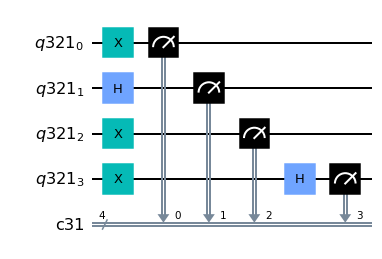

In [11]:
SEND_QC.draw('mpl')

The above mentioned string is Bob's observation of the Superposition. **This belongs to Bob only**

Now, Alice and Bob has shared their random strings with one another and Bob has observed the Qubits that were in Superposition (sent by Alice).

Given the public information i.e. Rotation Keys, Alice and Bob will generate a secret quantum encryption/decryption key.

**If a bit in Alice's rotation string is the same as the corresponding bit in Bob's, they know that Bob's result is the same as what Alice sent.**

(In brief, both the keys should be the same) (Alice based on her original key/Initial Key and Bob based on his measured results/Bob_results).

In [12]:
print("Random Key:\t\t\t\t", key)
print("Alice's Rotation Key:\t", A_rot)
print("Bob's Rotation Key:\t\t", B_rot)
print("Bob's Result:\t\t\t", Bob_result)

Random Key:				 111000111100110100001110010010110001011
Alice's Rotation Key:	 000001010100110110010011100111110000001
Bob's Rotation Key:		 000100010100111100001100011101001100100
Bob's Result:			 111001111100111100001010000010111101111


In [13]:
# using the public data i.e. Bob's and Alice's rotation keys
# if a bit in the rotated string is the same in both Alice's and Bob's string! voila, keep this and generate the whole key

# check for one - one correspondence in the measured outcomes
def KeyGen(rot_1, rot_2, results):
    key = ''
    count = 0
    for i,j in zip(rot_1, rot_2):
        if i == j:
            key += results[count]
        count += 1
    return key

In [14]:
A_key = KeyGen(B_rot, A_rot, key)
print("Alice's key:", A_key)

Alice's key: 11101111001110000011


In [15]:
B_key = KeyGen(B_rot, A_rot, Bob_result)
print("Bob's key:", B_key)

Bob's key: 11101111001110000011


In [16]:
if A_key == B_key:
    print('The key is a match!')
else:
    print('Error, Key not matched')

The key is a match!


As you can see, the keys are a perfect match, if they were not, someone tried to eavesdrop on your superpositon.

<b> Note: In practice this doesn't happen, there is a lot of noise that gets added to this and thereby the keys don't match. Inorder to overcome this we need to mitigate the errors by taking multiple measurements. </b>

Now we have a secure key that no one knows, we can use **THIS** key to encrypt and decrypt messages

### Encryption & Decryption

In [17]:
# Alice will encode a message with the above mentioned key
# shorten the key as it is longer and we have added extra digits at the end
short_A_key = A_key[:len(message)]
encoded_mess = ''

# encrypt it to produce an encrypted message
for letter_mes, int_key in zip(message, short_A_key):
    # basically shifts the ord(k) by 10 units (in ASCII) # can use any other encryption methods.
    encd_char = chr(ord(letter_mes) + (10 + ord(int_key)) % 256)
    encoded_mess += encd_char

print('Alice\'s Encoded Message:', encoded_mess)

# send this encoded message to bob

Alice's Encoded Message:  §¦ª[­°  ©


In [18]:
# Bob will use his key (which should be the same) to break the encryption
short_B_key = B_key[:len(message)]
decoded_mess = ''

for letter_mes, int_key in zip(encoded_mess, short_B_key):
    # basically shifts the ord(k) by 10 units (in ASCII)
    decd_char = chr(ord(letter_mes) - (10 + ord(int_key)) % 256)
    decoded_mess += decd_char

print('Bob\'s Decoded Message:', decoded_mess)

Bob's Decoded Message: Hello Praveen


# Presence of Eve

### Eve is eavesdropping!

Inorder to simulate what will happen if a third person tries to listen to this communication.

Consider Eve is trying to listen what Alice sent to Bob. Eve knows Alice's and Bob's Public Rotation Keys.

Alice has sent a superposition of random qubits to Bob. Now Eve tries to read these qubits and listen to Alice's and Bob's conversation. Consider the situation where Alice has sent Bob a superposition of the qubits and Eve tries to measure them.


In [19]:
# Eve tries to eavesdrop
# Eve has captured the qubits and then she applies an X gate to flip them and an H gate to rotate it in the opposite direction as Bob would do.
# but now the Superposition is broken as Eve has measured the qubit.

# now Eve generates Eve_results similar to Bob_results.
Eve_result = ''

# break the message in length of less than 5 bits for 5 qubit operation. (chunks of 5 bits)
# break_message contains how the message/string is divided
for loc, BM_num in enumerate(break_message):
    if BM_num < num_qbits:
        temp_key = key[num_qbits*loc:num_qbits*loc+BM_num]
        # Eve uses Public rotation key of Alice to try to decode the string
        A_r_temp = A_rot[num_qbits*loc:num_qbits*loc+BM_num]
    else:
        temp_key = key[BM_num*loc:BM_num*(loc+1)]
        A_r_temp = A_rot[BM_num*loc:BM_num*(loc+1)]

    print("temp_key, A_r_temp, B_r_temp:", temp_key, A_r_temp, B_r_temp)

    # quantum computer takes over from here
    # generate a register (classical and quantum) and a quantum circuit
    q = QuantumRegister(BM_num)
    c = ClassicalRegister(BM_num)
    Eve_QC = QuantumCircuit(q, c)

    # prepare qubits based on key; add Hadamard gates based on Alice's and Bob's rotation strings
    for i, j, n in zip(temp_key, A_r_temp, range(0, len(temp_key))):
        i = int(i)
        j = int(j)
        if i > 0:
            Eve_QC.x(q[n])
            print("applied X gate")
        if j > 0:
            Eve_QC.h(q[n])
            print("applied H gate")
        Eve_QC.measure(q[n], c[n])

    Eve_result += (list(execute(Eve_QC, backend, shots=1).result().get_counts(Eve_QC).keys())[0][::-1])

    print()

print("Eve's results: ", Eve_result)

temp_key, A_r_temp, B_r_temp: 11100 00000 0100
applied X gate
applied X gate
applied X gate

temp_key, A_r_temp, B_r_temp: 01111 10101 0100
applied H gate
applied X gate
applied X gate
applied H gate
applied X gate
applied X gate
applied H gate

temp_key, A_r_temp, B_r_temp: 00110 00110 0100
applied X gate
applied H gate
applied X gate
applied H gate

temp_key, A_r_temp, B_r_temp: 10000 11001 0100
applied X gate
applied H gate
applied H gate
applied H gate

temp_key, A_r_temp, B_r_temp: 11100 00111 0100
applied X gate
applied X gate
applied X gate
applied H gate
applied H gate
applied H gate

temp_key, A_r_temp, B_r_temp: 10010 00111 0100
applied X gate
applied H gate
applied X gate
applied H gate
applied H gate

temp_key, A_r_temp, B_r_temp: 11000 11000 0100
applied X gate
applied H gate
applied X gate
applied H gate

temp_key, A_r_temp, B_r_temp: 1011 0001 0100
applied X gate
applied X gate
applied X gate
applied H gate

Eve's results:  111000101100100000011101010010100001010


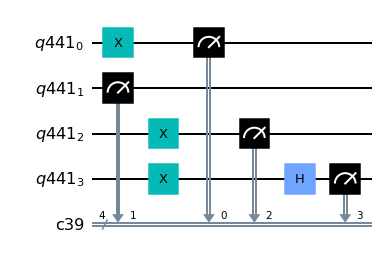

In [20]:
Eve_QC.draw('mpl')

## Intercept & Resend Attack

<img src="https://github.com/praveentn/ml-repos/blob/master/qc/qiskit/qkd/qkd_intercept_resend_attack_dtree.png?raw=true" />

#### Intercept & Resend Attack Using Superposition

Since Eve read/observed the superposition the wave function collapsed. Now if Bob doesn't recieve any communication, he would know someone was tring to eavesdrop.

Now, Eve tries to be sneaky and tries to generate a superposition of qubits and sends it to Bob so that he doesn't become suspicious.

In [21]:
# this will generate the superposition generated by Eve which she sends to Bob
# stores the result generated by Eve from the measured qubits!
Bob_bad_result = ''

# the code is similar to the above one
for loc, BM_num in enumerate(break_message):
    if BM_num < num_qbits:
        temp_key = key[num_qbits*loc:num_qbits*loc+BM_num]
        temp_eve = Eve_result[num_qbits*loc:num_qbits*loc+BM_num]
        B_r_temp = B_rot[num_qbits*loc:num_qbits*loc+BM_num]
    else:
        temp_key = key[BM_num*loc:BM_num*(loc+1)]
        temp_eve = Eve_result[BM_num*loc:BM_num*(loc+1)]
        B_r_temp = B_rot[BM_num*loc:BM_num*(loc+1)]

    print("temp_key, A_r_temp, B_r_temp:", temp_key, A_r_temp, B_r_temp)

    # create a quantum circuit to generate superposition as per Eve_results
    q = QuantumRegister(BM_num)
    c = ClassicalRegister(BM_num)
    Eve_2_QC = QuantumCircuit(q, c)

    # prepare qubits and send the superpositon
    for i, j, n in zip(temp_eve, B_r_temp, range(0, len(temp_key))):
        i = int(i)
        j = int(j)
        if i > 0:
            Eve_2_QC.x(q[n])
            print("applied X gate")
        if j > 0:
            Eve_2_QC.h(q[n])
            print("applied H gate")

        # technically, Eve will send the superposition of qubits from here to Bob
        Eve_2_QC.measure(q[n], c[n])

    # At Bob's site this is what he will observe!
    Bob_bad_result += list(execute(Eve_2_QC, backend, shots=1).result().get_counts(Eve_2_QC).keys())[0][::-1]

    print()

# original result
print("Bob's previous results (w/o Eve):", Bob_result)

# bad/intercepted result
print("Bob's results from Eve:\t\t", Bob_bad_result)

temp_key, A_r_temp, B_r_temp: 11100 0001 00010
applied X gate
applied X gate
applied X gate
applied H gate

temp_key, A_r_temp, B_r_temp: 01111 0001 00101
applied X gate
applied H gate
applied X gate
applied X gate
applied H gate

temp_key, A_r_temp, B_r_temp: 00110 0001 00111
applied X gate
applied H gate
applied H gate
applied H gate

temp_key, A_r_temp, B_r_temp: 10000 0001 10000
applied H gate
applied X gate

temp_key, A_r_temp, B_r_temp: 11100 0001 11000
applied X gate
applied H gate
applied X gate
applied H gate
applied X gate

temp_key, A_r_temp, B_r_temp: 10010 0001 11101
applied X gate
applied H gate
applied H gate
applied H gate
applied X gate
applied H gate

temp_key, A_r_temp, B_r_temp: 11000 0001 00110
applied X gate
applied H gate
applied H gate

temp_key, A_r_temp, B_r_temp: 1011 0001 0100
applied X gate
applied H gate
applied X gate

Bob's previous results (w/o Eve): 111001111100111100001010000010111101111
Bob's results from Eve:		 11110010100000100001110101011110000101

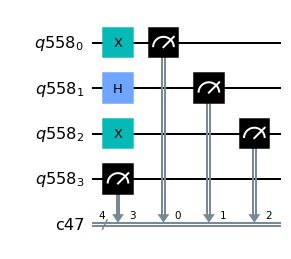

In [22]:
Eve_2_QC.draw('mpl')

Bob should have obsvered the first result (w/o Eve), however since Eve tried to eavesdrop and generate a new random superposition, Bob will recieve a new superposition of qubits.

The next cell will show that if Bob tries to generate a key, it will be different than what Alice will generate. Thereby, Bob won't be able to decrypt the message that Alice has sent!

In [23]:
# make keys for Alice and Bob with the bad result Eve sent
A_key_new = KeyGen(B_rot, A_rot, key)
B_key_new = KeyGen(B_rot, A_rot, Bob_bad_result)

print("Alice's key:   ", A_key_new)
print("Bob's new key: ", B_key_new)

if not A_key_new == B_key_new:
    # this is just for our reference
    print("Keys don't match!")

Alice's key:    11101111001110000011
Bob's new key:  11101010000000011011
Keys don't match!


In [24]:
# Bob will use his key (which should be the same) to break the encryption
short_B_key = B_key_new[:len(message)]
decoded_mess = ''

for letter_mes, int_key in zip(encoded_mess, short_B_key):
    # basically shifts the ord(k) by 10 units (in ASCII)
    decd_char = chr (ord(letter_mes) - (10 + ord(int_key)) % 256)
    decoded_mess += decd_char

print('Bob\'s Decoded message:', decoded_mess)

Bob's Decoded message: Hello!Psavffo


Since the keys don't match, the encrypted text that Alice will send, Bob won't be able to decrypt it. But how will both Alice and Bob check this?

Inorder to check the descrepancy, Alice will generate a Check Key, i.e., a random key same as the length of the `A_new_key`. She will then send this random key to Bob who will check his `B_new_key` for discrepancies.

In [25]:
# generate a random key by Alice and send it to Bob
check_key = RandomStringG(len(A_key_new))
print('Bits to check:', check_key)

Bits to check: 10101111110011000111


In [26]:
# with the help of publicly known keys, i.e., Alice rotation Key and Bob Rotation Key and now Check Key
# after recieving this key, both Alice and Bob will check for the position of the binary digit '1' in the Check Key and generate a Sub_key

# this is ALice side
# find the values in the roation keys that were used to make the KEY, here Initial Key
A_key_rot = KeyGen(B_rot, A_rot, A_rot)

# Inorder to detect Eve's interference, extract a subset of Alice's key 
sub_A_key = ''
count = 0
for i, j in zip(A_rot, A_key_new):
    if int(check_key[count]) == 1:
        sub_A_key += A_key_new[count]
    count += 1

# print the faulty subsection of public keys and send it to Bob
print("Subset of Alice's key:", sub_A_key)

# this is Bob side
# find the values in the roation keys that were used to make the KEY, here Bob_result
B_key_rot = KeyGen(B_rot, A_rot, B_rot)

# extract a subset of Bob's key
sub_B_key = ''
count = 0
for i, j in zip(B_rot, B_key_new):
    if int(check_key[count]) == 1:
        sub_B_key += B_key_new[count]

    count += 1

# print the faulty subsection of public keys and send it to Alice
print("Subset of Bob's key:", sub_B_key)

# now Alice and Bob sends their faulty keys (which are AVAILABLE IN PUBLIC, as they were shared) to one another 
# compare Alice's and Bob's key subsets

secure = True
for i, j in zip(sub_A_key, sub_B_key):
    if i == j:
        secure = True
    else:
        secure = False
        break;

if not secure:
    print('Eve detected!')
else:
    print('No eavesdropper detected!')


Subset of Alice's key: 1111110010011
Subset of Bob's key: 1110100000011
Eve detected!


### Note: It is important to have longer keys so that it becomes easier to detect the presence of Eve

#### Intercept & Resend Attack Using Entanglement

In [27]:
# this will generate the entanglement generated by Eve which she sends to Bob
# stores the result genrated by Eve from the measured qubits!
Bob_bad_result_entangled = ''

# the code is similar to the above one
for loc, BM_num in enumerate(break_message):
    if BM_num < num_qbits:
        temp_key = key[num_qbits*loc:num_qbits*loc+BM_num]
        temp_eve = Eve_result[num_qbits*loc:num_qbits*loc+BM_num]
        B_r_temp = B_rot[num_qbits*loc:num_qbits*loc+BM_num]
    else:
        temp_key = key[BM_num*loc:BM_num*(loc+1)]
        temp_eve = Eve_result[BM_num*loc:BM_num*(loc+1)]
        B_r_temp = B_rot[BM_num*loc:BM_num*(loc+1)]

    print("temp_key, A_r_temp, B_r_temp:", temp_key, A_r_temp, B_r_temp)

    # create a quantum circuit to generate superposition as per Eve_results
    q = QuantumRegister(BM_num)
    c = ClassicalRegister(BM_num)
    Eve_3_QC = QuantumCircuit(q, c)

    # prepare qubits and send the superpositon
    for i, j, n in zip(temp_eve, B_r_temp, range(0, len(temp_key))):
        i = int(i)
        j = int(j)

        if n == 0:
            # apply Hadamard
            Eve_3_QC.h(q[n])

            # create entanglement
            if n < num_qbits - 1:
                Eve_3_QC.cx(q[n], q[n+1])
        else:
            print(n)
            if n < num_qbits - 2:
                Eve_3_QC.ccx(q[0], q[n], q[n+1])

        # measurement
        for p in range(n + 1):
            Eve_3_QC.measure(q[p], c[p])

    # At Bob's site this is what he will observe!
    Bob_bad_result_entangled += list(execute(Eve_3_QC, backend, shots=1).result().get_counts(Eve_3_QC).keys())[0][::-1]
    print("Bob_bad_result_entangled:", Bob_bad_result_entangled)

    print()

# original result
print("Bob's previous results (without Eve):", Bob_result)

# bad/intercepted result
print("Bob's results from Eve:  \t\t", Bob_bad_result_entangled)

temp_key, A_r_temp, B_r_temp: 11100 0001 00010
1
2
3
4
Bob_bad_result_entangled: 00000

temp_key, A_r_temp, B_r_temp: 01111 0001 00101
1
2
3
4
Bob_bad_result_entangled: 0000011110

temp_key, A_r_temp, B_r_temp: 00110 0001 00111
1
2
3
4
Bob_bad_result_entangled: 000001111011110

temp_key, A_r_temp, B_r_temp: 10000 0001 10000
1
2
3
4
Bob_bad_result_entangled: 00000111101111011110

temp_key, A_r_temp, B_r_temp: 11100 0001 11000
1
2
3
4
Bob_bad_result_entangled: 0000011110111101111011110

temp_key, A_r_temp, B_r_temp: 10010 0001 11101
1
2
3
4
Bob_bad_result_entangled: 000001111011110111101111000000

temp_key, A_r_temp, B_r_temp: 11000 0001 00110
1
2
3
4
Bob_bad_result_entangled: 00000111101111011110111100000000000

temp_key, A_r_temp, B_r_temp: 1011 0001 0100
1
2
3
Bob_bad_result_entangled: 000001111011110111101111000000000001111

Bob's previous results (without Eve): 111001111100111100001010000010111101111
Bob's results from Eve:  		 000001111011110111101111000000000001111


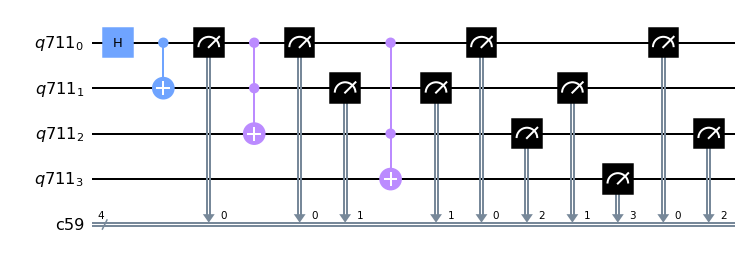

In [28]:
Eve_3_QC.draw('mpl')

### work-in-progress